In [101]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from joblib import Parallel, delayed
import matplotlib
from scipy.spatial.distance import pdist, squareform
from numba import jit, float32

In [99]:
def average_degree(g):
    return np.average([v for k, v in g.degree()])

def connectance(g):
    m = len(g.edges())
    n = len(g.nodes())
    return 2*m/(n*(n-1))

def assortativity(g):
    return nx.degree_assortativity_coefficient(g)

def bw_centrality(g):
    j = nx.betweenness_centrality(g)
    return np.average([j[k] for k in j])

def eig_centrality(g):
    j = nx.eigenvector_centrality(g)
    return np.average([j[k] for k in j])

def clustering(g):
    return nx.average_clustering(g)

def mean_pl(g):
    largest=g.subgraph(max(nx.connected_components(g), key=len)).copy()
    return nx.average_shortest_path_length(largest)

def num_node(g):
    return len(g.nodes())

def num_edge(g):
    return len(g.edges())

In [100]:
def sir(g):
    model = ep.SIRModel(g)
    config = mc.Configuration()
    config.add_model_parameter('beta', 0.01)
    config.add_model_parameter('gamma', 0.005)
    config.add_model_parameter("fraction_infected", 0.05)
    model.set_initial_status(config)
    iterations = model.iteration_bunch(5000)
    trends = model.build_trends(iterations)
    return np.sum(trends[0]['trends']['node_count'][1])/len(g.nodes())

def si(g):
    model = ep.SIModel(g)
    config = mc.Configuration()
    config.add_model_parameter('beta', 0.01)
    config.add_model_parameter("fraction_infected", 0.05)
    model.set_initial_status(config)
    iterations = model.iteration_bunch(5000)
    trends = model.build_trends(iterations)
    return np.sum(trends[0]['trends']['node_count'][1])/len(g.nodes())

def sis(g):
    model = ep.SISModel(g)
    config = mc.Configuration()
    config.add_model_parameter('beta', 0.01)
    config.add_model_parameter('lambda', 0.005)
    config.add_model_parameter("fraction_infected", 0.05)
    model.set_initial_status(config)
    iterations = model.iteration_bunch(5000)
    trends = model.build_trends(iterations)
    return np.sum(trends[0]['trends']['node_count'][1])/len(g.nodes())

def seir(g):
    model = ep.SEIRModel(g)
    config = mc.Configuration()
    config.add_model_parameter('beta', 0.01)
    config.add_model_parameter('gamma', 0.005)
    config.add_model_parameter('alpha', 0.05)
    config.add_model_parameter("fraction_infected", 0.05)
    model.set_initial_status(config)
    iterations = model.iteration_bunch(5000)
    trends = model.build_trends(iterations)
    return np.sum(trends[0]['trends']['node_count'][1])/len(g.nodes())

def seis(g):
    model = ep.SEISModel(g)
    config = mc.Configuration()
    config.add_model_parameter('beta', 0.01)
    config.add_model_parameter('lambda', 0.005)
    config.add_model_parameter('alpha', 0.05)
    config.add_model_parameter("fraction_infected", 0.05)
    model.set_initial_status(config)
    iterations = model.iteration_bunch(5000)
    trends = model.build_trends(iterations)
    return np.sum(trends[0]['trends']['node_count'][1])/len(g.nodes())

In [11]:
props = [num_node, num_edge, average_degree, connectance, assortativity, bw_centrality, eig_centrality, clustering, mean_pl]
models = [si, sir, sis, seis, seir]

In [26]:
def get_properties(g):
    props_dict = {}
    for prop in props:
        print("finding", prop.__name__)
        try:
            props_dict[prop.__name__] = prop(g)
        except:
            props_dict[prop.__name__] = np.na
    return props_dict

In [27]:
def run_sims(g):
    sims = {}
    for sim_type in [si, sir, sis, seis, seir]:
        print("running model", sim_type.__name__)
        sims[sim_type.__name__] = sim_type(g)
    return sims

In [28]:
def run_everything(g, i=0, total=0):
    print("Running for graph", i, "of", total)
    props = get_properties(g)
    sim_vals = run_sims(g)
    return props, sim_vals

In [107]:
def make_correlation_plots(data):
    figure, axis = plt.subplots(len(props), len(models), figsize=(15,30))
    pearson_correl = np.zeros((len(props), len(models)))
    distance_correl = np.zeros((len(props), len(models)))
    for i, prop in enumerate(props):
        for j, model in enumerate(models):
            xvals = []
            yvals = []
            for datum in data:
                xvals.append(datum[0][prop.__name__])
                yvals.append(datum[1][model.__name__])
            axis[i, j].scatter(xvals, yvals)
            axis[i, j].set_title(model.__name__ + " vs " + (prop.__name__))
            distance_correl[i, j] = distcorr(np.array(xvals)[~np.isnan(xvals)], np.array(yvals)[~np.isnan(xvals)])
            pearson_correl[i, j] = np.corrcoef(np.array(xvals)[~np.isnan(xvals)], np.array(yvals)[~np.isnan(xvals)])[0, 1]
            
    plt.show()
    return pearson_correl, distance_correl

In [86]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    if not ax:
        ax = plt.gca()
    im = ax.imshow(data, **kwargs)
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "black"),
                     threshold=None, **textkw):
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)
    return texts
def func(x, pos):
    return "{:.2f}".format(x).replace("0.", ".").replace("1.00", "")

In [102]:
def distcorr(X, Y):
    X = np.atleast_1d(X)
    Y = np.atleast_1d(Y)
    if np.prod(X.shape) == len(X):
        X = X[:, None]
    if np.prod(Y.shape) == len(Y):
        Y = Y[:, None]
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)
    n = X.shape[0]
    if Y.shape[0] != X.shape[0]:
        raise ValueError('Number of samples must match')
    a = squareform(pdist(X))
    b = squareform(pdist(Y))
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()
    
    dcov2_xy = (A * B).sum()/float(n * n)
    dcov2_xx = (A * A).sum()/float(n * n)
    dcov2_yy = (B * B).sum()/float(n * n)
    dcor = np.sqrt(dcov2_xy)/np.sqrt(np.sqrt(dcov2_xx) * np.sqrt(dcov2_yy))
    return dcor

In [90]:
graph_paths = ["../"+i.strip() for i in open("../good_ones").readlines()]
all_graphs = []
for i, path in enumerate(graph_paths):
    #print("Reading network data", i+1, "of", len(graph_paths))
    all_graphs.append(nx.read_graphml(path))

In [ ]:
data = Parallel(n_jobs=8)(delayed(run_everything)(i) for i in all_graphs)

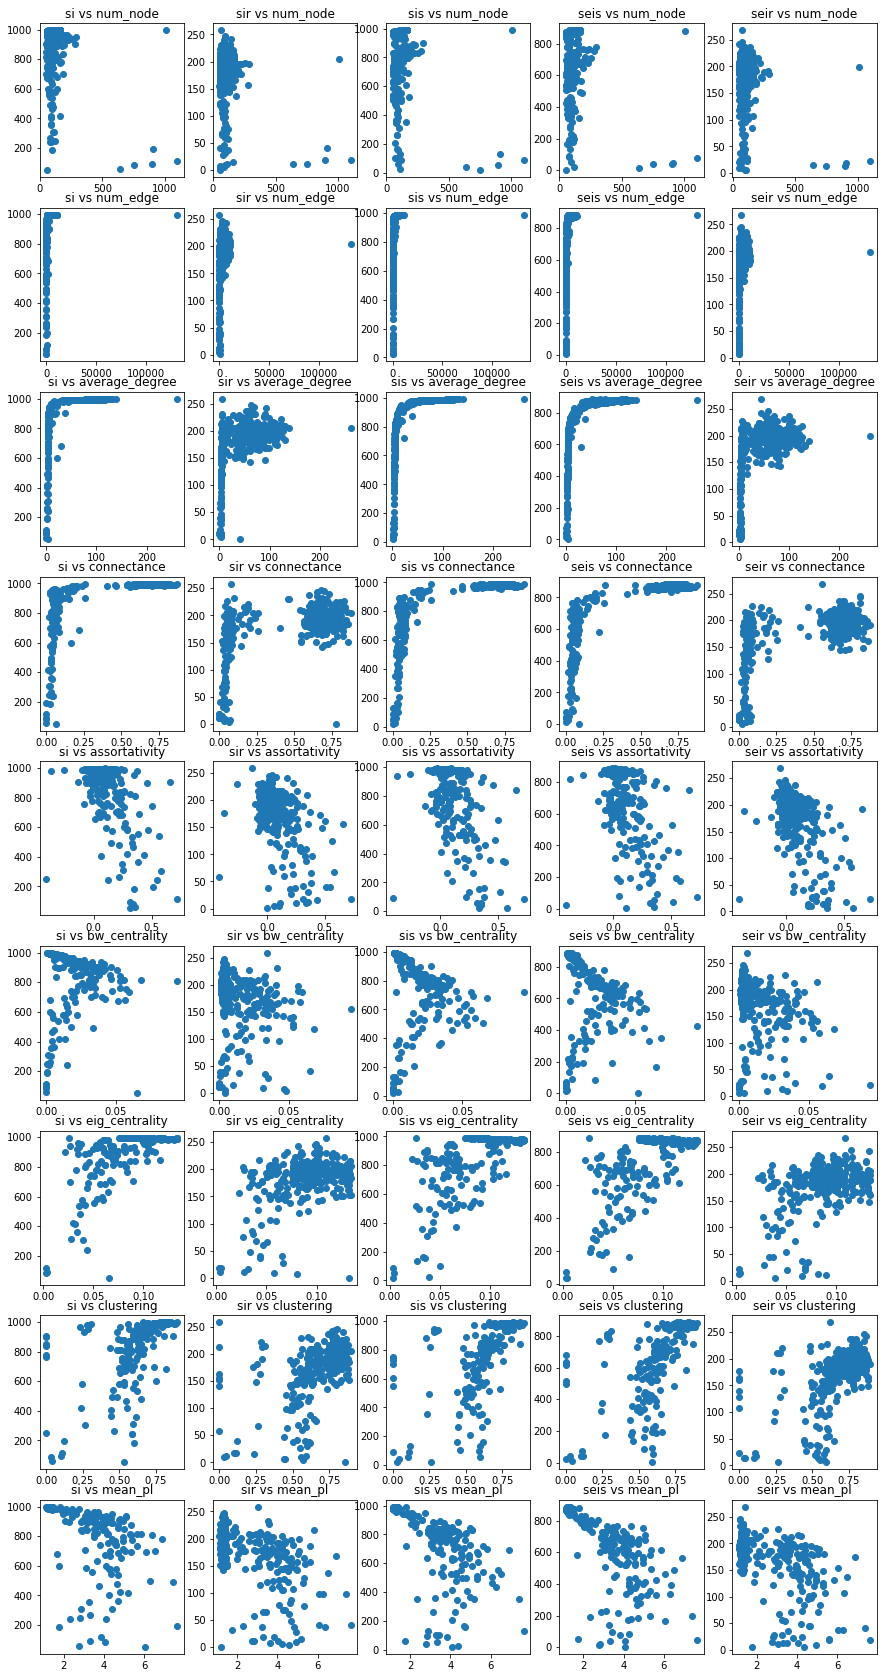

In [112]:
p_c, d_c = make_correlation_plots(data)

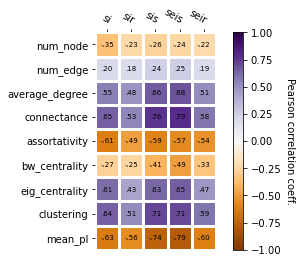

In [111]:
im2, f2 = heatmap(p_c, [prop.__name__ for prop in props], [model.__name__ for model in models],
                cmap="PuOr", vmin=-1, vmax=1,
                cbarlabel="Pearson correlation coeff.")

annotate_heatmap(im2, valfmt=matplotlib.ticker.FuncFormatter(func), size=7);

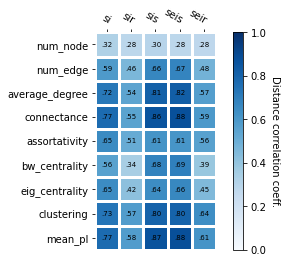

In [113]:
im1, f1 = heatmap(d_c, [prop.__name__ for prop in props], [model.__name__ for model in models],
                cmap="Blues", vmin=0, vmax=1,
                cbarlabel="Distance correlation coeff.")
annotate_heatmap(im1, valfmt=matplotlib.ticker.FuncFormatter(func), size=7);